In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
sys.path.append("/local/storage/ly349/projects/Deconvolution/Notebooks/")
from utils import get_bioqueue_file

In [ ]:
def agg_func(job_dict, func="median", read_out="CCC"):
    eval_res = []
    for k, v in job_dict.items():
        hq_eval_file, mq_eval_file, lq_eval_file = v
        hq_res_df = pd.read_csv(hq_eval_file)
        assert all([c in hq_res_df.columns for c in ("Transform", "Model", read_out)]), hq_res_df
        hq_agg_res_df = hq_res_df.loc[
            hq_res_df["Transform"]=="log", 
            ["Model", read_out]
        ].groupby("Model").agg(func)
        
        mq_res_df = pd.read_csv(mq_eval_file)
        assert all([c in mq_res_df.columns for c in ("Transform", "Model", read_out)]), mq_res_df
        mq_agg_res_df = mq_res_df.loc[
            mq_res_df["Transform"]=="log", 
            ["Model", read_out]
        ].groupby("Model").agg(func)

        lq_res_df = pd.read_csv(lq_eval_file)
        assert all([c in lq_res_df.columns for c in ("Transform", "Model", read_out)]), lq_res_df
        lq_agg_res_df = lq_res_df.loc[
            lq_res_df["Transform"]=="log", 
            ["Model", read_out]
        ].groupby("Model").agg(func)

        cond_df = hq_agg_res_df.join(mq_agg_res_df, lsuffix="_HQ", rsuffix="_MQ")
        cond_df = cond_df.join(lq_agg_res_df, rsuffix="_LQ").reset_index()
        cond_df.rename(columns={read_out: f"{read_out}_LQ"}, inplace=True)
        cond_df["Dataset"] = k
        # cond_df["Condition"] = cond_idx
        eval_res.append(cond_df)
    return pd.concat(eval_res)

In [5]:
init_eval_jobs = {
    "5D1": (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17082-v0.1.0-AHHKM10A-25M-MQ-dataset-5D1-4k-naive-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17100-v0.1.0-AHHKM10A-20M-LQ-dataset-5D1-4k-naive-eval.csc.csv.gz}}"),
    ),
    "5D2": (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17082-v0.1.0-AHHKM10A-25M-MQ-dataset-5D1-4k-naive-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17101-v0.1.0-CCGLM7-20M-LQ-dataset-5D2-rpm-4k-naive-eval.csc.csv.gz}}"),
    ),
}
pr_eval_jobs = {
    "5D3": (
            get_bioqueue_file("{{History:25136-v0.2.0-5D3-ACHLM-quasiPROseq-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17092-v0.1.0-ACHLM-25M-MQ-dataset-5D3-quasiPROseq-dREG-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17104-v0.1.0-ACHLM-20M-LQ-dataset-5D3-quasiPROseq-dREG-eval.csc.csv.gz}}"),
    ),
    "5D4": (
            get_bioqueue_file("{{History:25137-v0.2.0-5D4-ACHHL-quasiPROseq-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17093-v0.1.0-ACHHL-25M-MQ-dataset-5D4-quasiPROseq-dREG-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17105-v0.1.0-ACHHL-20M-LQ-dataset-5D4-quasiPROseq-dREG-eval.csc.csv.gz}}"),
    ),
}
hist_eval_jobs = {
    "CCHHM_K4me3": (
            get_bioqueue_file("{{History:15606-v0.1.0-5D_CCHHM-H3K4me3-fullCov-all-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17148-v0.1.0-CCHHM-H3K4me3_BWE-MQ-4k-dataset-tagAlign-fullCov-all-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17156-v0.1.0-CCHHM-H3K4me3_BWE-LQ-4k-dataset-tagAlign-fullCov-all-eval.csc.csv.gz}}"),
    ),
    "KGHHH_K27ac": (
            get_bioqueue_file("{{History:15277-v0.1.0-5D_KGHHH-H3K27ac-fullCov-all-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17147-v0.1.0-KGHHH-H3K27ac-MQ-4k-dataset-tagAlign-fullCov-all-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17157-v0.1.0-KGHHH-H3K27ac-LQ-4k-dataset-tagAlign-fullCov-all-eval.csc.csv.gz}}"),
    ),
}

In [6]:
shape_df = pd.concat([
    agg_func(init_eval_jobs),
    agg_func(pr_eval_jobs),
    agg_func(hist_eval_jobs)
], ignore_index=True)

(shape_df.CCC_HQ - shape_df.CCC_MQ).abs().describe(), (shape_df.CCC_HQ - shape_df.CCC_MQ).describe(), (shape_df.CCC_MQ - shape_df.CCC_LQ).describe()

(count    18.000000
 mean      0.013465
 std       0.011528
 min       0.002439
 25%       0.004740
 50%       0.010116
 75%       0.016053
 max       0.042067
 dtype: float64,
 count    18.000000
 mean      0.009876
 std       0.014886
 min      -0.014216
 25%       0.003156
 50%       0.006972
 75%       0.016053
 max       0.042067
 dtype: float64,
 count    18.000000
 mean      0.062201
 std       0.027019
 min       0.031131
 25%       0.037650
 50%       0.054941
 75%       0.094479
 max       0.099112
 dtype: float64)

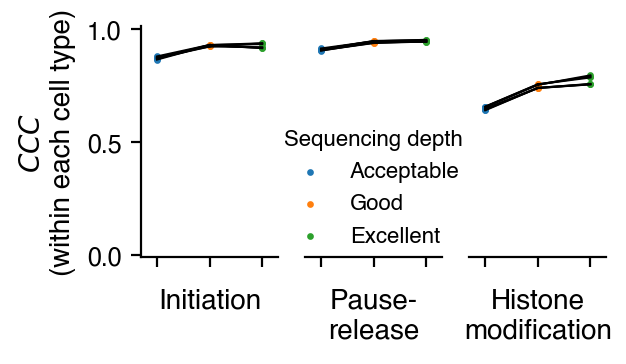

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3, 1.5), sharex=True, sharey=True)
ax = axs[0]
sub_df = agg_func(init_eval_jobs, "median")[["CCC_LQ", "CCC_MQ", "CCC_HQ"]]

ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )

plt.xticks(ind, ["", "", ""])
ax.set_xlabel("Initiation")

ax = axs[1]
sub_df = agg_func(pr_eval_jobs, "median")[["CCC_LQ", "CCC_MQ", "CCC_HQ"]]

ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2,
               label={"CCC_LQ": "Acceptable", "CCC_MQ": "Good", "CCC_HQ": "Excellent"}[i]
              )
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
plt.xticks(ind, ["", "", ""])
ax.set_xlabel("Pause-\nrelease")
ax.legend(loc="center", bbox_to_anchor=(0.5, 0.3), ncol=1, title="Sequencing depth")

ax = axs[2]
sub_df = agg_func(hist_eval_jobs, "median")[["CCC_LQ", "CCC_MQ", "CCC_HQ"]]

ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
plt.xticks(ind, ["", "", ""])
ax.set_xlabel("Histone\nmodification")

for i, ax in enumerate(axs):
    ax.set_xlim((-0.3, 2.3))
    ax.set_ylim((-0.01, 1.01))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    if i > 0:
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="y", left=False)
    else:
        ax.set_ylabel(r"$CCC$"+"\n(within each cell type)")

In [ ]:
init_eval_jobs = {
    "5D1": (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17082-v0.1.0-AHHKM10A-25M-MQ-dataset-5D1-4k-naive-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17100-v0.1.0-AHHKM10A-20M-LQ-dataset-5D1-4k-naive-eval.crc.csv.gz}}"),
    ),
    "5D2": (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17082-v0.1.0-AHHKM10A-25M-MQ-dataset-5D1-4k-naive-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17101-v0.1.0-CCGLM7-20M-LQ-dataset-5D2-rpm-4k-naive-eval.crc.csv.gz}}"),
    ),
}
pr_eval_jobs = {
    "5D3": (
            get_bioqueue_file("{{History:25136-v0.2.0-5D3-ACHLM-quasiPROseq-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17092-v0.1.0-ACHLM-25M-MQ-dataset-5D3-quasiPROseq-dREG-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17104-v0.1.0-ACHLM-20M-LQ-dataset-5D3-quasiPROseq-dREG-eval.crc.csv.gz}}"),
    ),
    "5D4": (
            get_bioqueue_file("{{History:25137-v0.2.0-5D4-ACHHL-quasiPROseq-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17093-v0.1.0-ACHHL-25M-MQ-dataset-5D4-quasiPROseq-dREG-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17105-v0.1.0-ACHHL-20M-LQ-dataset-5D4-quasiPROseq-dREG-eval.crc.csv.gz}}"),
    ),
}
hist_eval_jobs = {
    "CCHHM_K4me3": (
            get_bioqueue_file("{{History:15606-v0.1.0-5D_CCHHM-H3K4me3-fullCov-all-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17148-v0.1.0-CCHHM-H3K4me3_BWE-MQ-4k-dataset-tagAlign-fullCov-all-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17156-v0.1.0-CCHHM-H3K4me3_BWE-LQ-4k-dataset-tagAlign-fullCov-all-eval.crc.csv.gz}}"),
    ),
    "KGHHH_K27ac": (
            get_bioqueue_file("{{History:15277-v0.1.0-5D_KGHHH-H3K27ac-fullCov-all-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17147-v0.1.0-KGHHH-H3K27ac-MQ-4k-dataset-tagAlign-fullCov-all-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17157-v0.1.0-KGHHH-H3K27ac-LQ-4k-dataset-tagAlign-fullCov-all-eval.crc.csv.gz}}"),
    ),
}

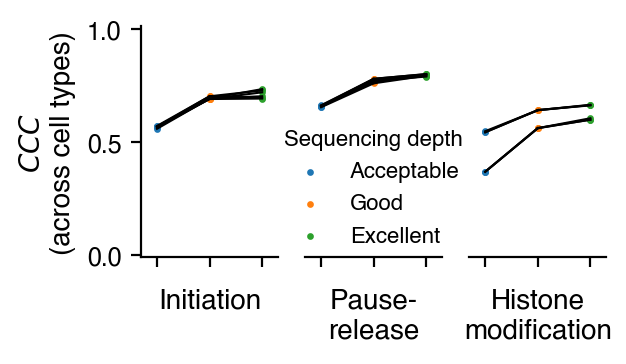

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3, 1.5), sharex=True, sharey=True)
ax = axs[0]
sub_df = agg_func(init_eval_jobs, "median")[["CCC_LQ", "CCC_MQ", "CCC_HQ"]]
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
plt.xticks(ind, ["", "", ""])
ax.set_xlabel("Initiation")

ax = axs[1]
sub_df = agg_func(pr_eval_jobs, "median")[["CCC_LQ", "CCC_MQ", "CCC_HQ"]]
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2,
               label={"CCC_LQ": "Acceptable", "CCC_MQ": "Good", "CCC_HQ": "Excellent"}[i])
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
plt.xticks(ind, ["", "", ""])
ax.set_xlabel("Pause-\nrelease")
ax.legend(loc="center", bbox_to_anchor=(0.5, 0.3), ncol=1, title="Sequencing depth")

ax = axs[2]
sub_df = agg_func(hist_eval_jobs, "median")[["CCC_LQ", "CCC_MQ", "CCC_HQ"]]
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
plt.xticks(ind, ["", "", ""])
ax.set_xlabel("Histone\nmodification")

for i, ax in enumerate(axs):
    ax.set_xlim((-0.3, 2.3))
    ax.set_ylim((-0.01, 1.01))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    if i > 0:
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="y", left=False)
    else:
        ax.set_ylabel(r"$CCC$"+"\n(across cell types)")